## Assigment 2: Word2vec and CBOW ⚡


In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [24]:
!pip install datasets
!gdown https://drive.google.com/file/d/1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu
To: /content/TestSet_sample.csv
100% 51.5k/51.5k [00:00<00:00, 28.6MB/s]


In [25]:
import torch
torch.manual_seed(0)

In this assigment we will use the data set wikitext. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [26]:
from datasets import load_dataset
from random import sample

wikitext = load_dataset("wikipedia", "20220301.simple")
trim_dataset= sample(wikitext['train']['text'], 5000)

Let's have a look at a datapoint.

In [27]:
trim_dataset[0]

'Substance is the material, or matter, of which something is made. Substances are physical things that can be seen, touched, or measured. They are made up of one or more elemental parts. Iron, aluminium, water and air are examples of substances.\n\nProblems of definition\n\nThe main problem of a clear definition of what the substance is that if, for example, to consider not just the universe (cosmos), being and non-being, and in general all, the question arises, what is the constant basic principle (attribute) is the basis of the substance, which generally consists of all (that is, matter, mind, senses, space, soul, and so on).\n\nHistory of the concept\n\nThe Latin word substantia - a translation of the Greek word for the essence (ousia), and in Latin to describe the essence of using the word essentia. In ancient philosophy substance is treated as a substrate, the first principle of all things (for example, "water" of Thales, the "fire" of Heraclitus). \n\nIn modern times, the concept

As you can see there are a lot of numeric values, end-of-lines and the word "References" at the end. We saw in the previous assigment how preprocessing can significantly reduce the vocabulary; feel free to base the following code in your previous work.

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
import string
import re
from nltk.corpus import stopwords
def preprocess_data(data):
  """ Method to clean text from noise and standarize text across the different classes.
      The preprocessing includes converting to joining all datapoints, lowercase, removing punctuation, and removing stopwords.
  Arguments
  ---------
  text : List of String
     Text to clean
  Returns
  -------
  text : String
      Cleaned and joined text
  """

  stop_words = set(stopwords.words('english'))

  text = ' '.join(data) #join all text in one single string
  text = text.lower() #make everything lower case
  text = text.replace('\n', ' ') #remove \n characters
  text = re.sub(r'\breferences\b', '', text) #remove word "References"
  text = text.translate(str.maketrans('', '', string.punctuation)) #remove any punctuation or special characters
  text = re.sub(r'\d+', '', text) #remove all numbers
  text = ' '.join([word for word in text.split() if word not in stop_words]) #remove all stopwords (see imports to help you with this)

  return text

text=preprocess_data(trim_dataset)

Our `text` variable includes all the data in just one string. Let's create a dictionary of frequencies for more pre-processing (same as in the last assigment).

In [30]:
def vocab_frequency(text):
  """ Creates dictionary of frequencies based on a dataset.
  Arguments
  ---------
  dataset : list of tuples
      list of tuples of the form (label, text)
  Returns
  -------
  vocab_dict : dictonary
      Dictionary of words and their frequencies with the format {word: frequency}
  """
  vocab_dict = {}

  for word in text.split(" "):
    if word in vocab_dict:
      vocab_dict[word] += 1
    else:
      vocab_dict[word] = 1
  return vocab_dict

vocabulary = vocab_frequency(text)

In [31]:
len(vocabulary)

504

Now our vocabulary is ready 😎

Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the vocabulary index to represent the words, so we will need the mapping: word -> index

In [32]:
import torch
import torch.nn as nn
def word_to_index(vocabulary):
  """ Method to create vocabulary to index mapping.
  Arguments
  ---------
  vocabulary : Dictionary
     Dictonary of format {word:frequency}
  Returns
  -------
  word_to_index : Dictionary
      Dictionary mapping words to index with format {word:index}
  """
  word_to_index = {"<OOV>": 0}
  #Create key,value pair for out of vocabulary worlds
  for idx, word in enumerate(vocabulary, start=1):
    word_to_index[word] = idx
  return word_to_index

word_to_index = word_to_index(vocabulary)

Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
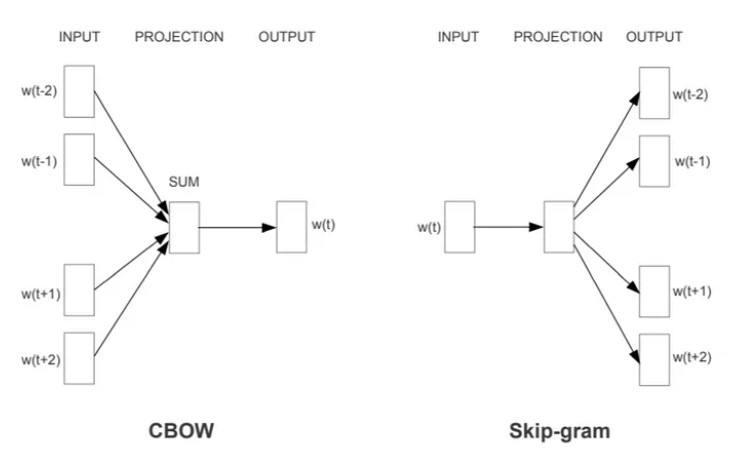

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


In [33]:
def generate_dataset(data, window_size,word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings= []
  targets = []
  data= data.split(" ")
  #TODO complete function
  for i in range(window_size,len(data)-window_size):
    surrounding = [word_to_index[data[j]] for j in range(i - window_size, i + window_size + 1) if j != i] #get surrounding words based on window size
    target = word_to_index[data[i]] #get target word (middle word)
    #append to surrounding
    surroundings.append(surrounding)
    #append to targets
    targets.append(target)
  surroundings = torch.tensor(surroundings, dtype=torch.long)
  targets = torch.tensor(targets, dtype=torch.long)
  return surroundings, targets

t_surroundings, t_targets = generate_dataset(text,2,word_to_index)

With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [34]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim) #use this layer to get a vector from the the word index
    self.linear = nn.Linear(embed_dim, vocab_size) #first fully connected layer (bottleneck)

  def forward(self, x):
    emb = self.embedding(x) #pass input through embedding layer
    average = emb.mean(dim=1) #average and resize (size must be batch_size x embed_dim)
    out = self.linear(average) #pass through linear layer

    return out

In [35]:
from torch.utils.data import DataLoader
#creation of dataloader for training
train_dataloader=DataLoader(list(zip(t_surroundings,t_targets)),batch_size=64,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)

In [36]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
model = CBOW(len(word_to_index)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

#BE PATIENT: This code can take up to 2 hours and 10 min for a batch size of 64 and 10 epochs
for epoch in range(epochs):
    total_loss = 0
    i=0
    for surr, tar in tqdm(train_dataloader):
        surr, tar = surr.to(device), tar.to(device)
        outputs = model(surr)
        loss = loss_function(outputs, tar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {total_loss/len(train_dataloader)}")

100%|██████████| 12/12 [00:00<00:00, 406.21it/s]


Epoch 1 loss: 6.258759260177612


100%|██████████| 12/12 [00:00<00:00, 300.70it/s]


Epoch 2 loss: 5.81834892431895


100%|██████████| 12/12 [00:00<00:00, 254.74it/s]


Epoch 3 loss: 5.426899393399556


100%|██████████| 12/12 [00:00<00:00, 232.96it/s]


Epoch 4 loss: 5.046012878417969


100%|██████████| 12/12 [00:00<00:00, 211.10it/s]


Epoch 5 loss: 4.673855821291606


100%|██████████| 12/12 [00:00<00:00, 198.11it/s]


Epoch 6 loss: 4.302071849505107


100%|██████████| 12/12 [00:00<00:00, 237.38it/s]


Epoch 7 loss: 3.9286625385284424


100%|██████████| 12/12 [00:00<00:00, 293.90it/s]


Epoch 8 loss: 3.5783042510350547


100%|██████████| 12/12 [00:00<00:00, 282.25it/s]


Epoch 9 loss: 3.2293990651766458


100%|██████████| 12/12 [00:00<00:00, 291.57it/s]

Epoch 10 loss: 2.89553572734197


## Let's test it! 🤓

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

In [37]:
def get_embedding(word, model, word_to_index):
    """ Method to get the embedding vector for a given word.
    Arguments
    ---------
    word : String
       Word given
    model : nn.Module
       CBOW model
    word_to_index : Dictionary
       Dictionary mapping words to index with format {word:index}
    Returns
    -------
    word_embedding : Tensor
        Embedding vector for the given word
    """
    # Get word index
    index = word_to_index.get(word, word_to_index['OOV'])

    with torch.no_grad():
        # Get the weights of the embedding layer
        embedding_weights = model.embedding.weight
        embedding_weights.requires_grad = False
        # Extract the embedding vector for the given word index
        word_embedding = embedding_weights[index]

    return word_embedding

# Test the function by getting embedding of the word "shot"
shot_embedding = get_embedding("shot", model, word_to_index)
print("Embedding for 'shot':")
print(shot_embedding)
print("Embedding shape:", shot_embedding.shape)

tensor([[[-1.1258, -1.1524, -0.2506,  ...,  0.8200, -0.6332,  1.2948],
         [ 1.4945, -0.5820,  1.0615,  ..., -0.3457,  0.2155, -0.3532],
         [ 0.1169,  2.4709,  1.3817,  ..., -1.0794,  1.1832, -0.5844],
         ...,
         [-0.3280, -0.7463,  1.4595,  ..., -0.4095,  0.0215, -1.0649],
         [ 1.1328, -1.8924, -0.7034,  ..., -0.5180, -2.5423, -0.5869],
         [ 1.7686, -0.1351,  0.2999,  ..., -0.9104, -0.3482, -0.5943]]],
       device='cuda:0')

In [38]:
def cosine_similarity(v1, v2):
    """ Method to calculate cosine similarity between two vectors.
    Arguments
    ---------
    v1 : Tensor
       First vector
    v2 : Tensor
       Second vector
    Returns
    -------
    cosine_similarity : float
        Cosine similarity between v1 and v2
    """
    return torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))

In [39]:
def get_k_nearest_words(k, word_embedding, vocabulary, model, word_to_index):
    """ Method to find the k nearest words of a given vector
    Arguments
    ---------
    k : int
       Number of nearest words to return
    word_embedding : torch.Tensor
       Embedding vector for the given word
    vocabulary : Dictionary
       Dictionary mapping words to frequency with format {word:frequency}
    model : nn.Module
       CBOW model
    word_to_index : Dictionary
       Dictionary mapping words to index with format {word:index}
    Returns
    -------
    similar : List of Strings
        List of k nearest words to the given word
    """
    similarity_scores = torch.zeros(len(vocabulary))

    # Fill similarity scores matrix using the word and our cosine_similarity function
    for i, word in enumerate(vocabulary.keys()):
        other_embedding = get_embedding(word, model, word_to_index)
        similarity_scores[i] = cosine_similarity(word_embedding, other_embedding)

    # Get the k highest similarity scores
    k_values, k_indices = torch.topk(similarity_scores, k + 1)  # +1 to account for the word itself

    similar = []
    for i in range(1, k + 1):  # Start from 1 to skip the word itself
        index = k_indices[i].item()
        word = list(vocabulary.keys())[index]
        similar.append(word)

    return similar

# Example usage:
word = "cat"
word_embedding = get_embedding(word, model, word_to_index)
nearest_words = get_k_nearest_words(10, word_embedding, vocabulary, model, word_to_index)
print(f"10 nearest words to '{word}': {nearest_words}")

The Google analogy test set is a state of the art data set for word embeddings that tests their ability to solve analogy tasks. A well-known example for it is: "king is to man as queen is to women." We will use a subset of this dataset to see how our CBOW model performs.


In [40]:
import pandas as pd

def test_analogy(model, word_to_index, analogy_file):
    """ Method to test accuracy of CBOW embeddings on analogy tasks.
    Arguments
    ---------
    model : nn.Module
       CBOW model
    word_to_index : Dictionary
       Dictionary mapping words to index with format {word:index}
    analogy_file : String
       File containing analogy tasks
    Returns
    -------
    accuracy : float
        accuracy of the model on the analogy tasks
    """
    df = pd.read_csv(analogy_file)
    df = df[df.category=='capital-common-countries']  # using capital cities subset of test set
    correct = 0
    total = 0

    for index, row in df.iterrows():
        # Extract words and standardize to lowercase
        word_one = row['word_one'].lower()
        word_two = row['word_two'].lower()
        word_three = row['word_three'].lower()
        word_four = row['word_four'].lower()

        try:
            # Get embeddings of all words
            emb_one = get_embedding(word_one, model, word_to_index)
            emb_two = get_embedding(word_two, model, word_to_index)
            emb_three = get_embedding(word_three, model, word_to_index)

            # Calculate result embedding
            result = emb_two - emb_one + emb_three

            # Get 10 nearest neighbors
            prediction = get_k_nearest_words(10, result, word_to_index, model, word_to_index)

            # Check if word_four is in prediction
            if word_four in prediction:
                correct += 1

            total += 1

        except KeyError:
            # Skip this analogy if any word is not in the vocabulary
            continue

    if total != 0:
        accuracy = correct / total
    else:
        return 'No word was found in the embeddings'

    return accuracy

# Test the analogy function
accuracy = test_analogy(model, word_to_index, 'TestSet_sample.csv')
print(f"Accuracy on analogy tasks: {accuracy}")

Total tasks skipped due to missing words: 506
No valid tasks were processed.


'No word was found in the embeddings'

Our model can do much better! In the "Let's experiment" part we will try to improve this model. Also depending on your GPU accesibility you can train for more epochs and data (making trim_dataset bigger in cell #3).

TSNE can be a very helpful and cool visualization method of our vectors, this way we can clearly see the relationship between different words (maybe even find some clusters!). Let's implement this visualization.

In [41]:
# import numpy as np
# import pandas as pd
# import torch
# import sys

# from sklearn.manifold import TSNE
# import plotly.graph_objects as go

# # Assuming the model is already defined and trained
# model.eval()

# # Get embeddings for the first 1000 words
# words = list(word_to_index.keys())[:1000]
# embeddings = model.embedding.weight.detach().cpu().numpy()[:1000]

# # Create TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_results = tsne.fit_transform(embeddings)

# # Create a DataFrame for easier plotting
# df = pd.DataFrame({
#     'x': tsne_results[:, 0],
#     'y': tsne_results[:, 1],
#     'word': words
# })

# # Create the plot
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=df['x'],
#     y=df['y'],
#     mode='markers+text',
#     text=df['word'],
#     textposition="top center",
#     hoverinfo='text',
#     marker=dict(size=5, color=df['x'], colorscale='Viridis', showscale=True)
# ))

# fig.update_layout(
#     title='t-SNE visualization of word embeddings',
#     xaxis_title='t-SNE dimension 1',
#     yaxis_title='t-SNE dimension 2',
#     width=1000,
#     height=800
# )

# fig.show()

## Let's Experiment!

Now it's your time to experiment.
- Find a new training corpus to train our CBOW model from scratch (it can be books, tweets, etc).  This should change the embeddings. Analyse and report how this new training set changes the vectors themselves and the accuracy on the analogy test.
- Test your embeddings on a different sub-section of the analogy dataset or another dataset. Analyse and report how these results compare with the original dataset.